In [ ]:

from __future__ import absolute_import
from __future__ import print_function
from datetime import datetime, timedelta
import os
from noaa_coops import Station
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import clawpack.visclaw.colormaps as colormap
import clawpack.visclaw.gaugetools as gaugetools
import clawpack.clawutil.data as clawutil
import clawpack.amrclaw.data as amrclaw
import clawpack.geoclaw.data as geodata
import clawpack.geoclaw.surge.plot as surgeplot
import csv
from clawpack.geoclaw.util import fetch_noaa_tide_data
from sklearn import metrics
import hydroeval as he
from sklearn.metrics import r2_score

landfall_time = np.datetime64("2012-10-29T23:30")
# begin_date = datetime.datetime(2008, 9, 4, 7, 20)
# end_date = datetime.datetime(2008, 9, 8, 19, 20)
flist =['8518750','8516945','8510560','8467150','8465705','8461490'] #NOAA tide gauges IDs

#Fetching NOAA tides and currents data and saving them as csv files

for k in flist:
    seattle = Station(str(k))
    df_water_levels = seattle.get_data(begin_date="20121026",
                                       end_date="20121031",
                                       product="water_level",
                                       datum="STND",units="metric",time_zone="gmt")
    del df_water_levels['s']
    del df_water_levels['f']
    del df_water_levels['q']
    df_tide = seattle.get_data(begin_date="20121026",
                                       end_date="20121031",
                                       product="predictions",
                                       datum="STND",units="metric",time_zone="gmt")

    df_water_levels['s']=df_water_levels['v']-df_tide['v']
    df_water_levels.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(k)+'_observed.csv', index = True)




#Organizing the simulated water levels and saving them as csv files
for i in range(1,7):
    df_simulated = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge0000'+str(i)+'.txt', skiprows = 4, sep='\s+',
                   header=None,
                   engine='python')
    df_simulated.columns = ['level','time','depth','u','v','surge']
    df_simulated['datetime'] = np.nan
    for j in range (len(df_simulated)):
        df_simulated.iloc[j,6]=pd.to_datetime(landfall_time)+ timedelta(seconds=df_simulated.iloc[j,1])+timedelta(hours = 3) #getting the datetime based on the landfall time and the relative second to the landfall
    df_simulated['datetime'] = pd.to_datetime(df_simulated['datetime']).dt.floor('S') #removing millisecond from the datetime
    df_simulated = df_simulated.set_index('datetime').resample('360s').mean()

    if i ==1:
        df_simulated.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_8518750_simulated.csv', index = True)
    elif i ==2:
        df_simulated.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_8516945_simulated.csv', index = True)
    elif i ==3:
        df_simulated.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_8510560_simulated.csv', index = True)
    elif i ==4:
        df_simulated.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_8467150_simulated.csv', index = True)
    elif i ==5:
        df_simulated.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_8465705_simulated.csv', index = True)
    else:
        df_simulated.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_8461490_simulated.csv', index = True)

df_evaluation_metrics = pd.DataFrame(index=np.arange(len(flist)))
df_evaluation_metrics['name'] = np.nan
df_evaluation_metrics['nse'] = np.nan
df_evaluation_metrics['kge'] = np.nan
df_evaluation_metrics['rmse'] = np.nan
df_evaluation_metrics['r2'] = np.nan
for z in flist:
    df_observed_extracted = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_observed.csv')
    df_observed_extracted.rename(columns = {'t':'datetime'}, inplace = True)
    df_observed_extracted.rename(columns = {'v':'flood_depth'}, inplace = True)
    df_observed_extracted.rename(columns = {'s':'surge'}, inplace = True)
    mask = (df_observed_extracted['datetime'] <= '2012-10-30 14:00:00')&(df_observed_extracted['datetime'] >= '2012-10-27 02:30:00')
    df_observed_extracted = df_observed_extracted.loc[mask]
    df_simulated_extracted = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_simulated.csv')
    df_simulated_extracted['datetime']=df_simulated_extracted['datetime'].astype('datetime64[ns]')
    df_observed_extracted['datetime']=df_observed_extracted['datetime'].astype('datetime64[ns]')
    mask = (df_simulated_extracted['datetime'] <= '2012-10-30 14:00:00')
    df_simulated_extracted = df_simulated_extracted.loc[mask]

    nse = he.evaluator(he.nse, df_simulated_extracted['surge'], df_observed_extracted['surge'])
    kge, r, alpha, beta = he.evaluator(he.kge, df_simulated_extracted['surge'], df_observed_extracted['surge'])
    r2 = r2_score(df_observed_extracted['surge'], df_simulated_extracted['surge'])
    rmse = np.sqrt(metrics.mean_squared_error(df_observed_extracted['surge'], df_simulated_extracted['surge']))

    if z==flist[0]:
            df_evaluation_metrics.iloc[0,0] = z
            df_evaluation_metrics.iloc[0,1] = nse
            df_evaluation_metrics.iloc[0,2] = kge
            df_evaluation_metrics.iloc[0,3] = rmse
            df_evaluation_metrics.iloc[0,4] = r2
    elif z==flist[1]:
            df_evaluation_metrics.iloc[1,0] = z
            df_evaluation_metrics.iloc[1,1] = nse
            df_evaluation_metrics.iloc[1,2] = kge
            df_evaluation_metrics.iloc[1,3] = rmse
            df_evaluation_metrics.iloc[1,4] = r2
    elif z==flist[2]:
            df_evaluation_metrics.iloc[2,0] = z
            df_evaluation_metrics.iloc[2,1] = nse
            df_evaluation_metrics.iloc[2,2] = kge
            df_evaluation_metrics.iloc[2,3] = rmse
            df_evaluation_metrics.iloc[2,4] = r2
    elif z==flist[3]:
            df_evaluation_metrics.iloc[3,0] = z
            df_evaluation_metrics.iloc[3,1] = nse
            df_evaluation_metrics.iloc[3,2] = kge
            df_evaluation_metrics.iloc[3,3] = rmse
            df_evaluation_metrics.iloc[3,4] = r2
    elif z==flist[4]:
            df_evaluation_metrics.iloc[4,0] = z
            df_evaluation_metrics.iloc[4,1] = nse
            df_evaluation_metrics.iloc[4,2] = kge
            df_evaluation_metrics.iloc[4,3] = rmse
            df_evaluation_metrics.iloc[4,4] = r2
    elif z==flist[5]:
            df_evaluation_metrics.iloc[5,0] = z
            df_evaluation_metrics.iloc[5,1] = nse
            df_evaluation_metrics.iloc[5,2] = kge
            df_evaluation_metrics.iloc[5,3] = rmse
            df_evaluation_metrics.iloc[5,4] = r2

    plt.plot(df_simulated_extracted['datetime'],df_simulated_extracted['surge'], color = 'red', label ='Simulated')
    plt.plot(df_observed_extracted['datetime'], df_observed_extracted['surge'], color = 'blue', label = 'Observed')
    plt.title(z+', Storm Surge')
    plt.legend()
    plt.xticks(rotation=90)
    plt.savefig(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_storm_surge.png')
    plt.show()

df_evaluation_metrics.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/evaluation_metrics_no_correction.csv', index = False)

ValueError: simulation and evaluation arrays feature incompatible dimensions

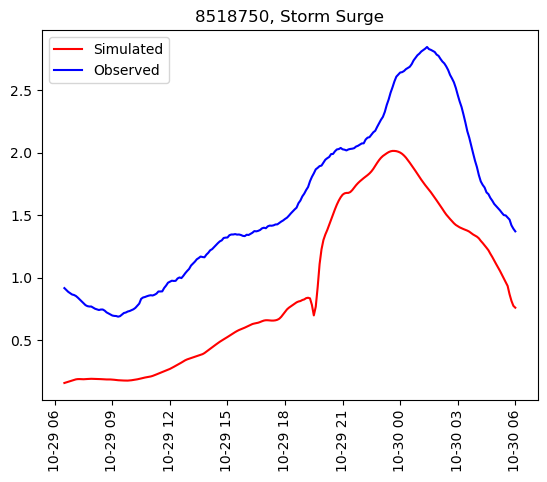

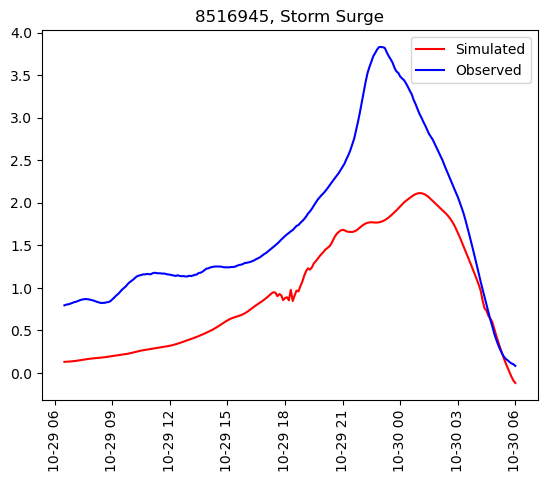

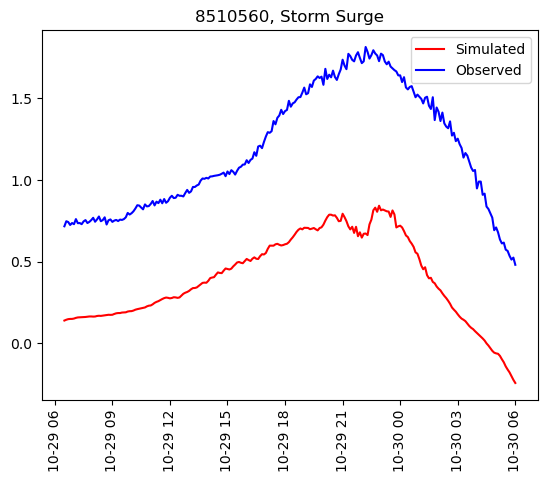

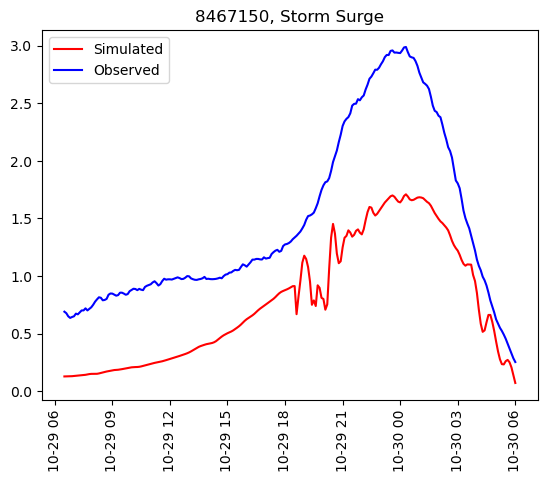

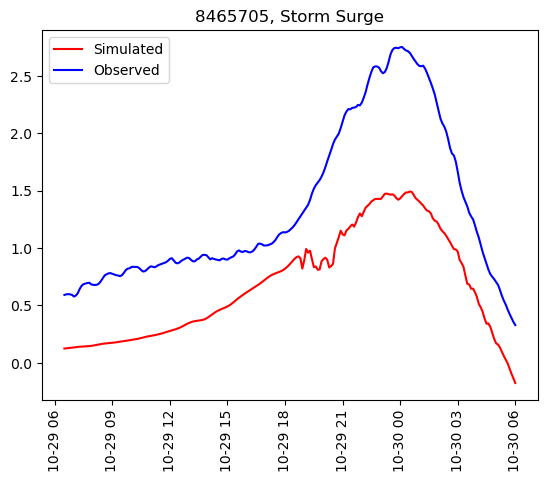

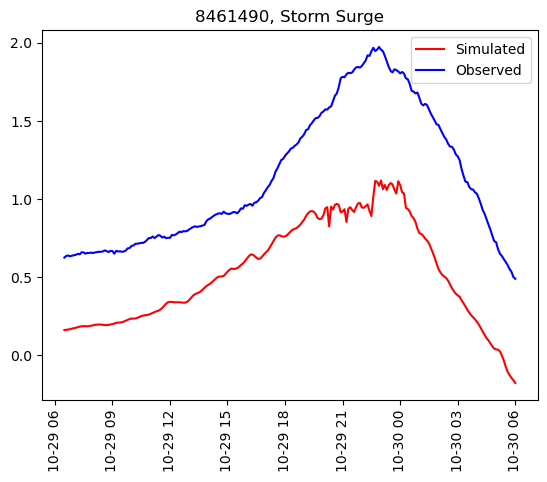

In [ ]:
#Maximum evaluation metrics
df_evaluation_metrics = pd.DataFrame(index=np.arange(len(flist)))
df_evaluation_metrics['name'] = np.nan
df_evaluation_metrics['nse'] = np.nan
df_evaluation_metrics['kge'] = np.nan
df_evaluation_metrics['rmse'] = np.nan
df_evaluation_metrics['r2'] = np.nan
for z in flist:
    df_observed_extracted = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_observed.csv')
    df_observed_extracted.rename(columns = {'t':'datetime'}, inplace = True)
    df_observed_extracted.rename(columns = {'v':'flood_depth'}, inplace = True)
    df_observed_extracted.rename(columns = {'s':'surge'}, inplace = True)
    mask = (df_observed_extracted['datetime'] <= '2012-10-30 06:00:00')&(df_observed_extracted['datetime'] >= '2012-10-29 06:30:00')
    df_observed_extracted = df_observed_extracted.loc[mask]
    df_simulated_extracted = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_simulated.csv')
    df_simulated_extracted['datetime']=df_simulated_extracted['datetime'].astype('datetime64[ns]')
    df_observed_extracted['datetime']=df_observed_extracted['datetime'].astype('datetime64[ns]')
    mask = (df_simulated_extracted['datetime'] <= '2012-10-30 06:00:00')&(df_simulated_extracted['datetime'] >= '2012-10-29 06:30:00')
    df_simulated_extracted = df_simulated_extracted.loc[mask]

    nse = he.evaluator(he.nse, df_simulated_extracted['surge'], df_observed_extracted['surge'])
    kge, r, alpha, beta = he.evaluator(he.kge, df_simulated_extracted['surge'], df_observed_extracted['surge'])
    r2 = r2_score(df_observed_extracted['surge'], df_simulated_extracted['surge'])
    rmse = np.sqrt(metrics.mean_squared_error(df_observed_extracted['surge'], df_simulated_extracted['surge']))

    if z==flist[0]:
            df_evaluation_metrics.iloc[0,0] = z
            df_evaluation_metrics.iloc[0,1] = nse
            df_evaluation_metrics.iloc[0,2] = kge
            df_evaluation_metrics.iloc[0,3] = rmse
            df_evaluation_metrics.iloc[0,4] = r2
    elif z==flist[1]:
            df_evaluation_metrics.iloc[1,0] = z
            df_evaluation_metrics.iloc[1,1] = nse
            df_evaluation_metrics.iloc[1,2] = kge
            df_evaluation_metrics.iloc[1,3] = rmse
            df_evaluation_metrics.iloc[1,4] = r2
    elif z==flist[2]:
            df_evaluation_metrics.iloc[2,0] = z
            df_evaluation_metrics.iloc[2,1] = nse
            df_evaluation_metrics.iloc[2,2] = kge
            df_evaluation_metrics.iloc[2,3] = rmse
            df_evaluation_metrics.iloc[2,4] = r2
    elif z==flist[3]:
            df_evaluation_metrics.iloc[3,0] = z
            df_evaluation_metrics.iloc[3,1] = nse
            df_evaluation_metrics.iloc[3,2] = kge
            df_evaluation_metrics.iloc[3,3] = rmse
            df_evaluation_metrics.iloc[3,4] = r2
    elif z==flist[4]:
            df_evaluation_metrics.iloc[4,0] = z
            df_evaluation_metrics.iloc[4,1] = nse
            df_evaluation_metrics.iloc[4,2] = kge
            df_evaluation_metrics.iloc[4,3] = rmse
            df_evaluation_metrics.iloc[4,4] = r2
    elif z==flist[5]:
            df_evaluation_metrics.iloc[5,0] = z
            df_evaluation_metrics.iloc[5,1] = nse
            df_evaluation_metrics.iloc[5,2] = kge
            df_evaluation_metrics.iloc[5,3] = rmse
            df_evaluation_metrics.iloc[5,4] = r2

    plt.plot(df_simulated_extracted['datetime'],df_simulated_extracted['surge'], color = 'red', label ='Simulated')
    plt.plot(df_observed_extracted['datetime'], df_observed_extracted['surge'], color = 'blue', label = 'Observed')
    plt.title(z+', Storm Surge')
    plt.legend()
    plt.xticks(rotation=90)
    plt.savefig(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/max_gauge_'+str(z)+'_storm_surge.png')
    plt.show()

df_evaluation_metrics.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/max_evaluation_metrics_no_correction.csv', index = False)

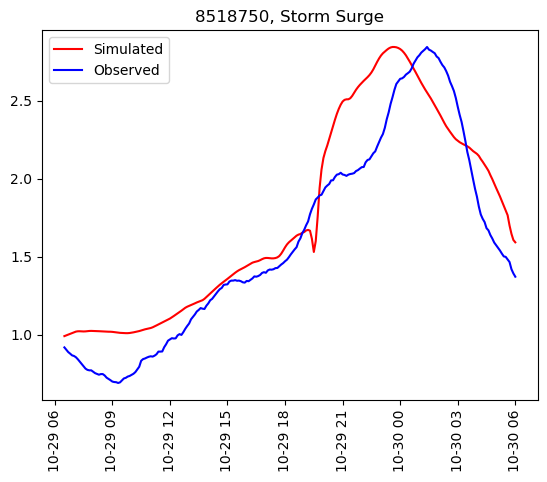

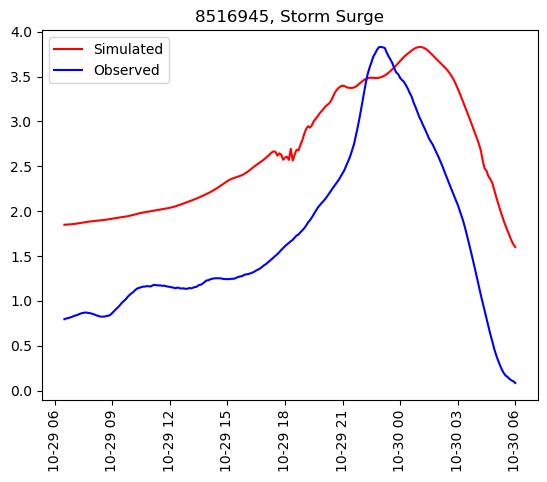

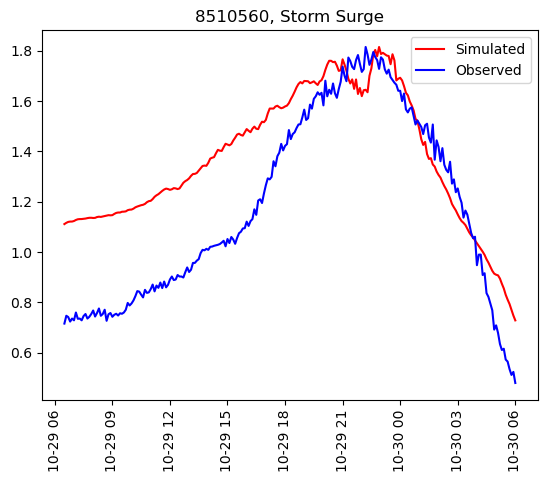

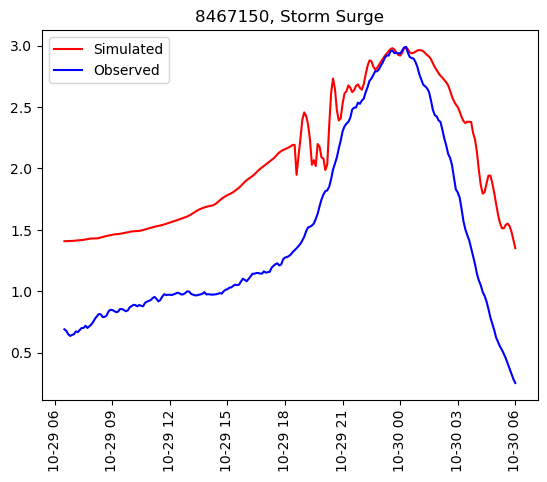

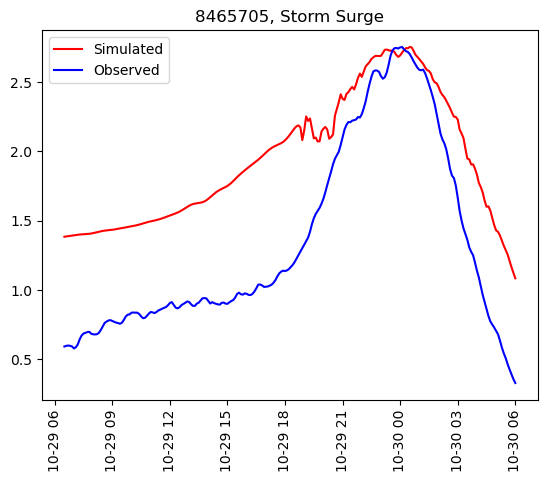

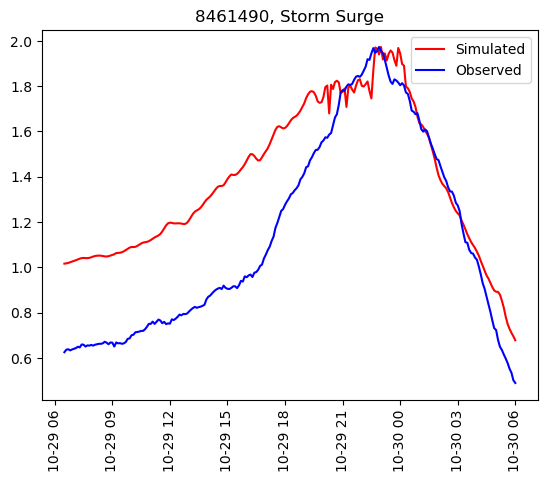

In [ ]:
#adding bias correction to simulations which have observed values
df_evaluation_metrics = pd.DataFrame(index=np.arange(len(flist)))
df_evaluation_metrics['name'] = np.nan
df_evaluation_metrics['nse'] = np.nan
df_evaluation_metrics['kge'] = np.nan
df_evaluation_metrics['rmse'] = np.nan
df_evaluation_metrics['r2'] = np.nan
for z in flist:
    df_observed_extracted = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_observed.csv')
    df_observed_extracted.rename(columns = {'t':'datetime'}, inplace = True)
    df_observed_extracted.rename(columns = {'v':'flood_depth'}, inplace = True)
    df_observed_extracted.rename(columns = {'s':'surge'}, inplace = True)
    mask = (df_observed_extracted['datetime'] <= '2012-10-30 06:00:00')&(df_observed_extracted['datetime'] >= '2012-10-29 06:30:00')
    df_observed_extracted = df_observed_extracted.loc[mask]
    df_simulated_extracted = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_simulated.csv')
    df_simulated_extracted['datetime']=df_simulated_extracted['datetime'].astype('datetime64[ns]')
    df_observed_extracted['datetime']=df_observed_extracted['datetime'].astype('datetime64[ns]')
    mask = (df_simulated_extracted['datetime'] <= '2012-10-30 06:00:00')&(df_simulated_extracted['datetime'] >= '2012-10-29 06:30:00')
    df_simulated_extracted = df_simulated_extracted.loc[mask]


    df_mean_sim = np.max(df_simulated_extracted['surge'])
    df_mean_obs = np.max(df_observed_extracted['surge'])
    mean_to_add = df_mean_obs-df_mean_sim

    df_simulated_extracted['surge'] = df_simulated_extracted['surge'] +mean_to_add

    df_mean_sim2 = np.max(df_simulated_extracted['depth'])
    df_mean_obs2 = np.max(df_observed_extracted['flood_depth'])
    mean_to_add2 = df_mean_obs2-df_mean_sim2

    df_simulated_extracted['depth'] = df_simulated_extracted['depth'] +mean_to_add2

    df_simulated_extracted.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/max_gauge_'+str(z)+'_simulated_biased_corrected.csv', index = False)


    nse = he.evaluator(he.nse, df_simulated_extracted['surge'], df_observed_extracted['surge'])
    kge, r, alpha, beta = he.evaluator(he.kge, df_simulated_extracted['surge'], df_observed_extracted['surge'])
    r2 = r2_score(df_observed_extracted['surge'], df_simulated_extracted['surge'])
    rmse = np.sqrt(metrics.mean_squared_error(df_observed_extracted['surge'], df_simulated_extracted['surge']))

    if z==flist[0]:
            df_evaluation_metrics.iloc[0,0] = z
            df_evaluation_metrics.iloc[0,1] = nse
            df_evaluation_metrics.iloc[0,2] = kge
            df_evaluation_metrics.iloc[0,3] = rmse
            df_evaluation_metrics.iloc[0,4] = r2
    elif z==flist[1]:
            df_evaluation_metrics.iloc[1,0] = z
            df_evaluation_metrics.iloc[1,1] = nse
            df_evaluation_metrics.iloc[1,2] = kge
            df_evaluation_metrics.iloc[1,3] = rmse
            df_evaluation_metrics.iloc[1,4] = r2
    elif z==flist[2]:
            df_evaluation_metrics.iloc[2,0] = z
            df_evaluation_metrics.iloc[2,1] = nse
            df_evaluation_metrics.iloc[2,2] = kge
            df_evaluation_metrics.iloc[2,3] = rmse
            df_evaluation_metrics.iloc[2,4] = r2
    elif z==flist[3]:
            df_evaluation_metrics.iloc[3,0] = z
            df_evaluation_metrics.iloc[3,1] = nse
            df_evaluation_metrics.iloc[3,2] = kge
            df_evaluation_metrics.iloc[3,3] = rmse
            df_evaluation_metrics.iloc[3,4] = r2
    elif z==flist[4]:
            df_evaluation_metrics.iloc[4,0] = z
            df_evaluation_metrics.iloc[4,1] = nse
            df_evaluation_metrics.iloc[4,2] = kge
            df_evaluation_metrics.iloc[4,3] = rmse
            df_evaluation_metrics.iloc[4,4] = r2
    elif z==flist[5]:
            df_evaluation_metrics.iloc[5,0] = z
            df_evaluation_metrics.iloc[5,1] = nse
            df_evaluation_metrics.iloc[5,2] = kge
            df_evaluation_metrics.iloc[5,3] = rmse
            df_evaluation_metrics.iloc[5,4] = r2

    plt.plot(df_simulated_extracted['datetime'],df_simulated_extracted['surge'], color = 'red', label ='Simulated')
    plt.plot(df_observed_extracted['datetime'], df_observed_extracted['surge'], color = 'blue', label = 'Observed')
    plt.title(z+', Storm Surge')
    plt.legend()
    plt.xticks(rotation=90)
    plt.savefig(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/max_gauge_'+str(z)+'_biased_corrected_storm_surge.png')

    plt.show()
df_evaluation_metrics.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/max_evaluation_metrics_corrected.csv', index =False)



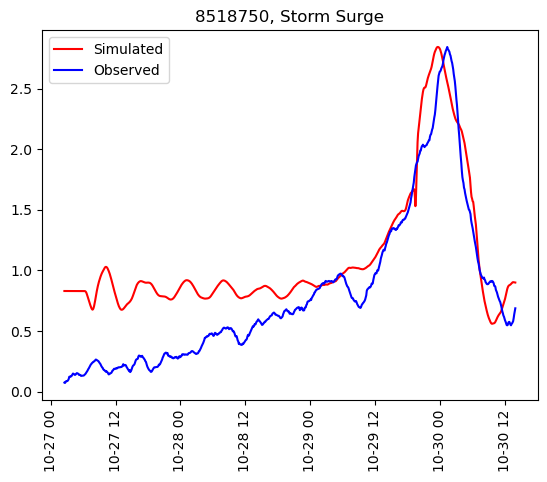

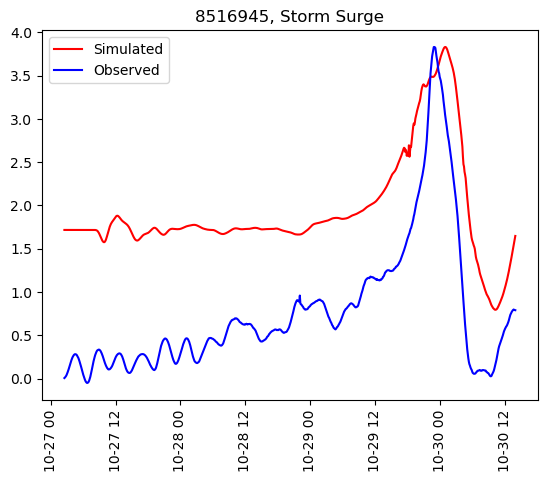

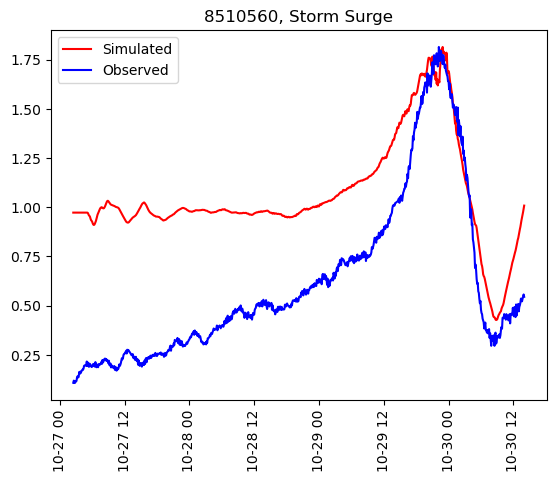

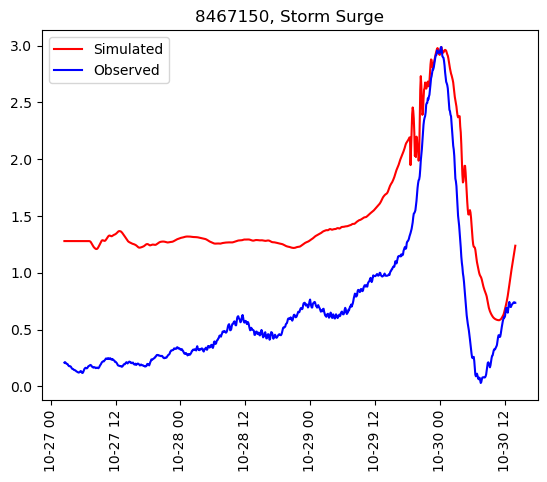

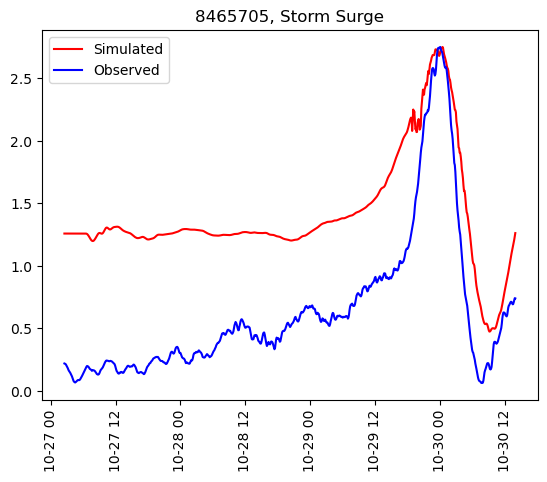

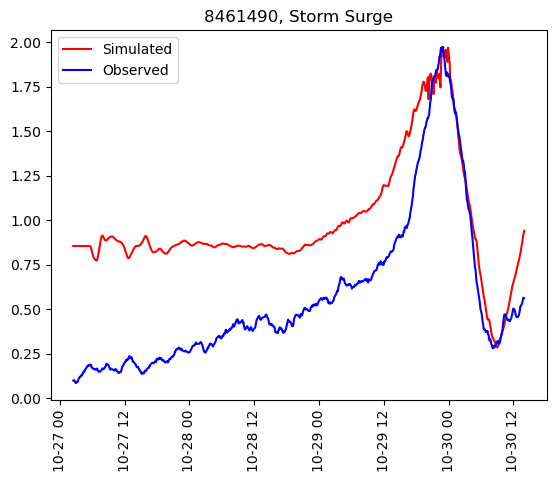

In [ ]:
#adding bias correction to simulations which have observed values
df_evaluation_metrics = pd.DataFrame(index=np.arange(len(flist)))
df_evaluation_metrics['name'] = np.nan
df_evaluation_metrics['nse'] = np.nan
df_evaluation_metrics['kge'] = np.nan
df_evaluation_metrics['rmse'] = np.nan
df_evaluation_metrics['r2'] = np.nan
for z in flist:
    df_observed_extracted = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_observed.csv')
    df_observed_extracted.rename(columns = {'t':'datetime'}, inplace = True)
    df_observed_extracted.rename(columns = {'v':'flood_depth'}, inplace = True)
    df_observed_extracted.rename(columns = {'s':'surge'}, inplace = True)
    mask = (df_observed_extracted['datetime'] <= '2012-10-30 14:00:00')&(df_observed_extracted['datetime'] >= '2012-10-27 02:30:00')
    df_observed_extracted = df_observed_extracted.loc[mask]
    df_simulated_extracted = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_simulated.csv')
    df_simulated_extracted['datetime']=df_simulated_extracted['datetime'].astype('datetime64[ns]')
    df_observed_extracted['datetime']=df_observed_extracted['datetime'].astype('datetime64[ns]')
    mask = (df_simulated_extracted['datetime'] <= '2012-10-30 14:00:00')
    df_simulated_extracted = df_simulated_extracted.loc[mask]


    df_mean_sim = np.max(df_simulated_extracted['surge'])
    df_mean_obs = np.max(df_observed_extracted['surge'])
    mean_to_add = df_mean_obs-df_mean_sim

    df_simulated_extracted['surge'] = df_simulated_extracted['surge'] +mean_to_add

    df_mean_sim2 = np.max(df_simulated_extracted['depth'])
    df_mean_obs2 = np.max(df_observed_extracted['flood_depth'])
    mean_to_add2 = df_mean_obs2-df_mean_sim2

    df_simulated_extracted['depth'] = df_simulated_extracted['depth'] +mean_to_add2

    df_simulated_extracted.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_simulated_biased_corrected.csv', index = False)



    nse = he.evaluator(he.nse, df_simulated_extracted['surge'], df_observed_extracted['surge'])
    kge, r, alpha, beta = he.evaluator(he.kge, df_simulated_extracted['surge'], df_observed_extracted['surge'])
    r2 = r2_score(df_observed_extracted['surge'], df_simulated_extracted['surge'])
    rmse = np.sqrt(metrics.mean_squared_error(df_observed_extracted['surge'], df_simulated_extracted['surge']))

    if z==flist[0]:
            df_evaluation_metrics.iloc[0,0] = z
            df_evaluation_metrics.iloc[0,1] = nse
            df_evaluation_metrics.iloc[0,2] = kge
            df_evaluation_metrics.iloc[0,3] = rmse
            df_evaluation_metrics.iloc[0,4] = r2
    elif z==flist[1]:
            df_evaluation_metrics.iloc[1,0] = z
            df_evaluation_metrics.iloc[1,1] = nse
            df_evaluation_metrics.iloc[1,2] = kge
            df_evaluation_metrics.iloc[1,3] = rmse
            df_evaluation_metrics.iloc[1,4] = r2
    elif z==flist[2]:
            df_evaluation_metrics.iloc[2,0] = z
            df_evaluation_metrics.iloc[2,1] = nse
            df_evaluation_metrics.iloc[2,2] = kge
            df_evaluation_metrics.iloc[2,3] = rmse
            df_evaluation_metrics.iloc[2,4] = r2
    elif z==flist[3]:
            df_evaluation_metrics.iloc[3,0] = z
            df_evaluation_metrics.iloc[3,1] = nse
            df_evaluation_metrics.iloc[3,2] = kge
            df_evaluation_metrics.iloc[3,3] = rmse
            df_evaluation_metrics.iloc[3,4] = r2
    elif z==flist[4]:
            df_evaluation_metrics.iloc[4,0] = z
            df_evaluation_metrics.iloc[4,1] = nse
            df_evaluation_metrics.iloc[4,2] = kge
            df_evaluation_metrics.iloc[4,3] = rmse
            df_evaluation_metrics.iloc[4,4] = r2
    elif z==flist[5]:
            df_evaluation_metrics.iloc[5,0] = z
            df_evaluation_metrics.iloc[5,1] = nse
            df_evaluation_metrics.iloc[5,2] = kge
            df_evaluation_metrics.iloc[5,3] = rmse
            df_evaluation_metrics.iloc[5,4] = r2

    plt.plot(df_simulated_extracted['datetime'],df_simulated_extracted['surge'], color = 'red', label ='Simulated')
    plt.plot(df_observed_extracted['datetime'], df_observed_extracted['surge'], color = 'blue', label = 'Observed')
    plt.title(z+', Storm Surge')
    plt.legend()
    plt.xticks(rotation=90)
    plt.savefig(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_biased_corrected_storm_surge.png')

    plt.show()
df_evaluation_metrics.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/evaluation_metrics_corrected.csv', index =False)





In [ ]:

from __future__ import absolute_import
from __future__ import print_function
from datetime import datetime, timedelta
import os
from noaa_coops import Station
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import clawpack.visclaw.colormaps as colormap
import clawpack.visclaw.gaugetools as gaugetools
import clawpack.clawutil.data as clawutil
import clawpack.amrclaw.data as amrclaw
import clawpack.geoclaw.data as geodata
import clawpack.geoclaw.surge.plot as surgeplot
import csv
from clawpack.geoclaw.util import fetch_noaa_tide_data
from sklearn import metrics
import hydroeval as he
from sklearn.metrics import r2_score

landfall_time = np.datetime64("2012-10-29T23:30")
#Organizing the simulated water levels and saving them as csv files
for i in range(7,10):
    df_simulated = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge0000'+str(i)+'.txt', skiprows = 4, sep='\s+',
                   header=None,
                   engine='python')
    df_simulated.columns = ['level','time','depth','u','v','surge']
    df_simulated['datetime'] = np.nan
    for j in range (len(df_simulated)):
        df_simulated.iloc[j,6]=pd.to_datetime(landfall_time)+ timedelta(seconds=df_simulated.iloc[j,1])+timedelta(hours=3) #getting the datetime based on the landfall time and the relative second to the landfall
    df_simulated['datetime'] = pd.to_datetime(df_simulated['datetime']).dt.floor('S') #removing millisecond from the datetime
    df_simulated = df_simulated.set_index('datetime').resample('360s').mean()
    df_simulated.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(i)+'_simulated.csv', index = True)


for i in range(10,18):
    df_simulated = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge000'+str(i)+'.txt', skiprows = 4, sep='\s+',
                   header=None,
                   engine='python')
    df_simulated.columns = ['level','time','depth','u','v','surge']
    df_simulated['datetime'] = np.nan
    for j in range (len(df_simulated)):
        df_simulated.iloc[j,6]=pd.to_datetime(landfall_time)+ timedelta(seconds=df_simulated.iloc[j,1])+timedelta(hours=3) #getting the datetime based on the landfall time and the relative second to the landfall
    df_simulated['datetime'] = pd.to_datetime(df_simulated['datetime']).dt.floor('S') #removing millisecond from the datetime
    df_simulated = df_simulated.set_index('datetime').resample('360s').mean()
    df_simulated.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(i)+'_simulated.csv', index = True)

for i in range(19,32):
    df_simulated = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge000'+str(i)+'.txt', skiprows = 4, sep='\s+',
                   header=None,
                   engine='python')
    df_simulated.columns = ['level','time','depth','u','v','surge']
    df_simulated['datetime'] = np.nan
    for j in range (len(df_simulated)):
        df_simulated.iloc[j,6]=pd.to_datetime(landfall_time)+ timedelta(seconds=df_simulated.iloc[j,1])+timedelta(hours=3) #getting the datetime based on the landfall time and the relative second to the landfall
    df_simulated['datetime'] = pd.to_datetime(df_simulated['datetime']).dt.floor('S') #removing millisecond from the datetime
    df_simulated = df_simulated.set_index('datetime').resample('360s').mean()
    df_simulated.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(i)+'_simulated.csv', index = True)


flist2 =['8518750']
for z in flist2:
    df_observed_extracted = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_observed.csv')
    df_observed_extracted.rename(columns = {'t':'datetime'}, inplace = True)
    df_observed_extracted.rename(columns = {'v':'flood_depth'}, inplace = True)
    df_observed_extracted.rename(columns = {'s':'surge'}, inplace = True)
    mask = (df_observed_extracted['datetime'] <= '2012-10-30 14:00:00')&(df_observed_extracted['datetime'] >= '2012-10-27 02:30:00')
    df_observed_extracted = df_observed_extracted.loc[mask]
    df_simulated_extracted = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(z)+'_simulated.csv')
    df_simulated_extracted['datetime']=df_simulated_extracted['datetime'].astype('datetime64[ns]')
    df_observed_extracted['datetime']=df_observed_extracted['datetime'].astype('datetime64[ns]')
    mask = (df_simulated_extracted['datetime'] <= '2012-10-30 14:00:00')
    df_simulated_extracted = df_simulated_extracted.loc[mask]


    df_mean_sim = np.max(df_simulated_extracted['surge'])
    df_mean_obs = np.max(df_observed_extracted['surge'])
    mean_to_add = df_mean_obs-df_mean_sim

    df_mean_sim2 = np.max(df_simulated_extracted['depth'])
    df_mean_obs2 = np.max(df_observed_extracted['flood_depth'])
    mean_to_add2 = df_mean_obs2-df_mean_sim2

    for k in range(7,18):
        df_simulated_no = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(k)+'_simulated.csv')
        df_simulated_no['surge'] = df_simulated_no['surge']+mean_to_add
        df_simulated_no['depth'] = df_simulated_no['depth']+mean_to_add2
        df_simulated_no.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(k)+'_simulated_biased_corrected_with_depth.csv', index = False)
    for k in range(19,32):
        df_simulated_no = pd.read_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(k)+'_simulated.csv')
        df_simulated_no['surge'] = df_simulated_no['surge']+mean_to_add
        df_simulated_no['depth'] = df_simulated_no['depth']+mean_to_add2
        df_simulated_no.to_csv(r'/home/jovyan/data/clawpack/geoclaw/examples/storm-surge/HurricaneSandy/_output/gauge_'+str(k)+'_simulated_biased_corrected_with_depth.csv', index = False)
